We start with the **static data** coming directly from the raw CSVs. This establishes a solid baseline to understand the nature of products and customers before introducing the **dynamic variables** generated by our simulation and injected chaos.


Based on `02_build_dwh_schema.py`, the tables that **survived** later script manipulation (Scripts 3, 4, and 5) and represent either direct transfers or minimal cleansing of the original data are:

**dwh.dim_products**
Source: `raw_products` + `raw_category_translation`
Status: Fully clean. No injected or derived business logic.

**dwh.dim_customers**
Source: `raw_customers`
Status: Pure geographic/customer location data. 100% real.

**dwh.fact_payments**
Source: `raw_payments`
Status: Original payment methods (credit card, installments, etc.). No transformations applied.

**dwh.fact_reviews**
Source: `raw_reviews`
Status: Genuine customer reviews and ratings (real sentiment).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sqlalchemy import text
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from nltk.sentiment import SentimentIntensityAnalyzer

In [2]:
%cd ..
import db_config
engine = db_config.get_engine()

D:\Project\olist\Olist-Decision-Engine
🏠 CONNECTING TO LOCAL DB: olist_engine_db


In [3]:
query_prod = "SELECT * FROM dwh.dim_products"
df_prods = pd.read_sql(query_prod, engine)
df_prods

,product_id,category,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,furniture_decor,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construction_tools_lights,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,bed_bath_table,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,computers_accessories,700.0,31.0,13.0,20.0


In [4]:
mask_bad_category = (
    df_prods["category"].isna() |
    (df_prods["category"].str.strip() == "") |
    (df_prods["category"] == "Unknown")
)

print(mask_bad_category.value_counts(),
(df_prods["category"] == "Unknown").value_counts())

category
False    32341
True       610
Name: count, dtype: int64 category
False    32341
True       610
Name: count, dtype: int64


In [5]:
cols = [
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm"
]

prod_missed = (
    df_prods[cols].isnull().any(axis=1) |
    (df_prods[cols] == 0).any(axis=1)
)

df_prods[prod_missed]

,product_id,category,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,baby,NaN,NaN,NaN,NaN
9769,81781c0fed9fe1ad6e8c81fca1e1cb08,bed_bath_table,0.0,30.0,25.0,30.0
13683,8038040ee2a71048d4bdbbdc985b69ab,bed_bath_table,0.0,30.0,25.0,30.0
14997,36ba42dd187055e1fbe943b2d11430ca,bed_bath_table,0.0,30.0,25.0,30.0
18851,5eb564652db742ff8f28759cd8d2652a,Unknown,NaN,NaN,NaN,NaN
32079,e673e90efa65a5409ff4196c038bb5af,bed_bath_table,0.0,30.0,25.0,30.0


In [6]:
def impute_product_weight_ml(df_prods, cols_dims):
    df = df_prods.copy()

    for col in cols_dims:
        medians = df.groupby('category')[col].transform('median')
        df[col] = df[col].fillna(medians)
        df[col] = df[col].fillna(df[col].median())

    df['volume_cm3'] = df[cols_dims].product(axis=1)

    mask_missing = df['product_weight_g'].isna() | (df['product_weight_g'] <= 0)
    train_df = df[~mask_missing].copy()
    predict_df = df[mask_missing].copy()

    if len(predict_df) == 0:
        return df, None, None

    le = LabelEncoder()
    all_cats = pd.concat([
        train_df['category'],
        predict_df['category']
    ]).astype(str).unique()

    le.fit(all_cats)

    train_df['cat_encoded'] = le.transform(train_df['category'].astype(str))
    predict_df['cat_encoded'] = le.transform(predict_df['category'].astype(str))

    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(
        train_df[['volume_cm3', 'cat_encoded']],
        train_df['product_weight_g']
    )

    predicted_weights = rf.predict(
        predict_df[['volume_cm3', 'cat_encoded']]
    )

    df.loc[mask_missing, 'product_weight_g'] = predicted_weights

    return df, train_df, predict_df.assign(predicted_weight=predicted_weights)

In [7]:
def plot_weight_imputation(train_df, predicted_df):
    if predicted_df is None or len(predicted_df) == 0:
        return

    plt.figure(figsize=(10, 6))

    sns.scatterplot(
        x=train_df['volume_cm3'],
        y=train_df['product_weight_g'],
        alpha=0.3,
        label='Real Data',
        color='#2D3270'
    )

    sns.scatterplot(
        x=predicted_df['volume_cm3'],
        y=predicted_df['predicted_weight'],
        alpha=0.6,
        label='Predicted (ML)',
        color='#F9D500'
    )

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Volume (cm3)')
    plt.ylabel('Weight (g)')
    plt.title('ML Imputation Validation: Volume vs Weight')
    plt.legend()
    plt.show()

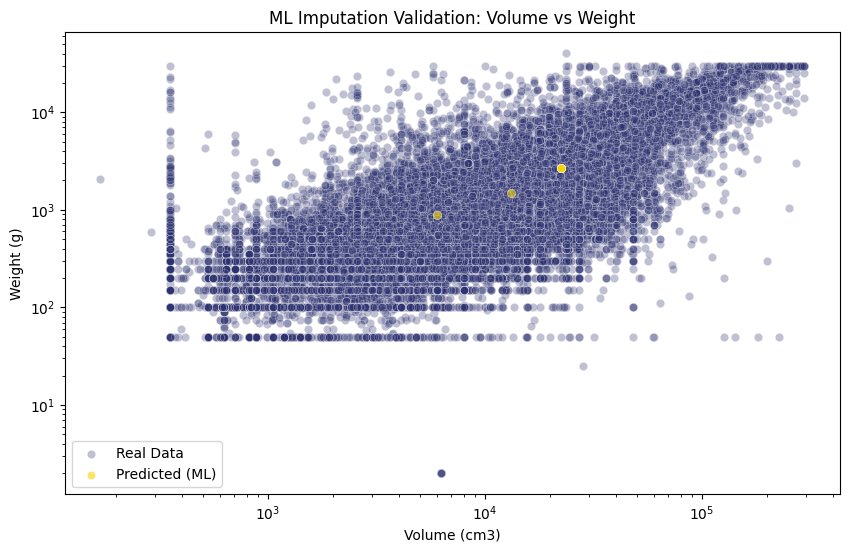

In [8]:
cols_dims = ['product_length_cm', 'product_height_cm', 'product_width_cm']

df_prods, train_df, predicted_df = impute_product_weight_ml(
    df_prods,
    cols_dims
)

plot_weight_imputation(train_df, predicted_df)

In [9]:
df_prods[prod_missed]

,product_id,category,product_weight_g,product_length_cm,product_height_cm,product_width_cm,volume_cm3
8578,09ff539a621711667c43eba6a3bd8466,baby,1489.119853,33.0,16.0,25.0,13200.0
9769,81781c0fed9fe1ad6e8c81fca1e1cb08,bed_bath_table,2679.997114,30.0,25.0,30.0,22500.0
13683,8038040ee2a71048d4bdbbdc985b69ab,bed_bath_table,2679.997114,30.0,25.0,30.0,22500.0
14997,36ba42dd187055e1fbe943b2d11430ca,bed_bath_table,2679.997114,30.0,25.0,30.0,22500.0
18851,5eb564652db742ff8f28759cd8d2652a,Unknown,894.194768,25.0,12.0,20.0,6000.0
32079,e673e90efa65a5409ff4196c038bb5af,bed_bath_table,2679.997114,30.0,25.0,30.0,22500.0


In [10]:
def impute_product_category_ml(df_prods):
    df = df_prods.copy()

    # --- Fill numeric features deterministically ---
    cols_dims = [
        'product_length_cm',
        'product_height_cm',
        'product_width_cm',
        'product_weight_g'
    ]

    for col in cols_dims:
        df[col] = df[col].fillna(df[col].median())

    # Feature engineering
    df['volume_cm3'] = (
        df['product_length_cm'] *
        df['product_height_cm'] *
        df['product_width_cm']
    )

    # Split
    mask_unknown = (
        df['category'].isna() |
        (df['category'] == 'Unknown')
    )

    train_df = df[~mask_unknown].copy()
    predict_df = df[mask_unknown].copy()

    if len(predict_df) == 0:
        return df, None

    # Encode target
    le = LabelEncoder()
    y_train = le.fit_transform(train_df['category'].astype(str))

    X_train = train_df[['product_weight_g', 'volume_cm3']]
    X_predict = predict_df[['product_weight_g', 'volume_cm3']]

    # Train classifier
    clf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)

    # Predict
    predicted_indices = clf.predict(X_predict)
    predicted_categories = le.inverse_transform(predicted_indices)

    # Inject back
    df.loc[mask_unknown, 'category'] = predicted_categories

    predicted_df = predict_df.assign(predicted_category=predicted_categories)

    return df, predicted_df

In [11]:
def plot_predicted_categories(predicted_df, top_n=10):
    if predicted_df is None or len(predicted_df) == 0:
        return

    top_counts = (
        predicted_df['predicted_category']
        .value_counts()
        .head(top_n)
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=top_counts.values,
        y=top_counts.index,
        palette='viridis'
    )

    plt.title('Top Categories Predicted for Previously Unknown Items')
    plt.xlabel('Count')
    plt.ylabel('Category')
    plt.show()

C:\Users\mfgas\AppData\Local\Temp\ipykernel_10196\945140887.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


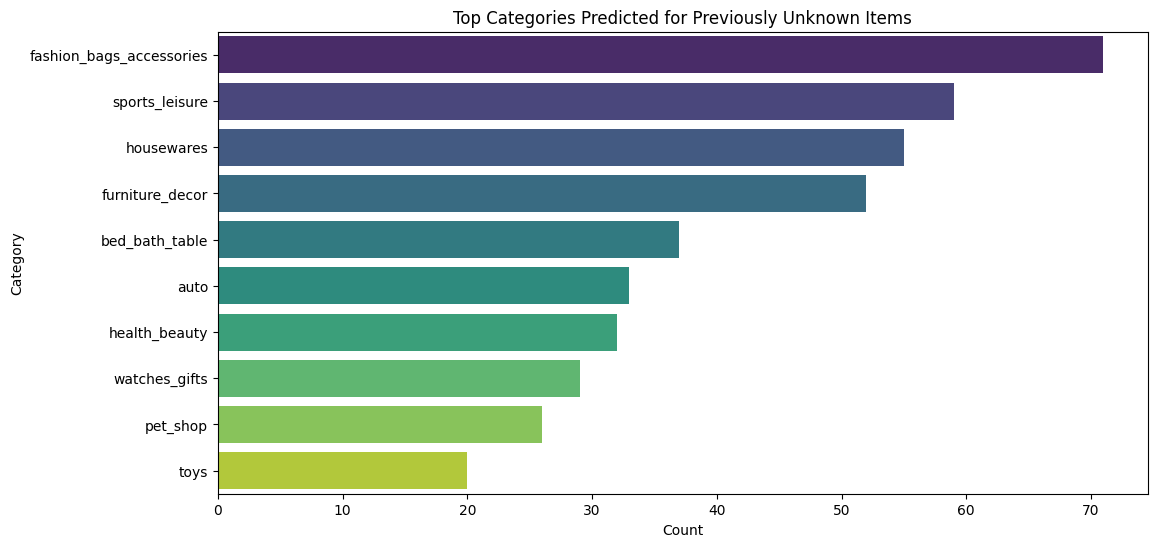

category
bed_bath_table           3066
sports_leisure           2926
furniture_decor          2709
health_beauty            2476
housewares               2390
auto                     1933
computers_accessories    1659
toys                     1431
watches_gifts            1358
telephony                1143
Name: count, dtype: int64
Remaining Unknown: 0


In [12]:
df_prods, predicted_df = impute_product_category_ml(df_prods)

plot_predicted_categories(predicted_df)

print(df_prods['category'].value_counts().head(10))
print(
    "Remaining Unknown:",
    (df_prods['category'] == 'Unknown').sum()
)

_____

In [13]:
query_cust = "SELECT * FROM dwh.dim_customers"
df_cust = pd.read_sql(query_cust, engine)
df_cust

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_state,customer_city
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,SP,franca
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,SP,sao bernardo do campo
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,SP,sao paulo
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,SP,mogi das cruzes
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,SP,campinas
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,SP,sao paulo
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,SP,taboao da serra
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,CE,fortaleza
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,RS,canoas


In [14]:
df_cust["customer_city"].value_counts(dropna=False)

customer_city
sao paulo                   15540
rio de janeiro               6882
belo horizonte               2773
brasilia                     2131
curitiba                     1521
                            ...  
olhos d'agua                    1
pacotuba                        1
sao sebastiao do paraiba        1
benedito leite                  1
campos verdes                   1
Name: count, Length: 4119, dtype: int64

In [15]:
query_pay = "SELECT * FROM dwh.fact_payments"
df_pay = pd.read_sql(query_pay, engine)
df_pay

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


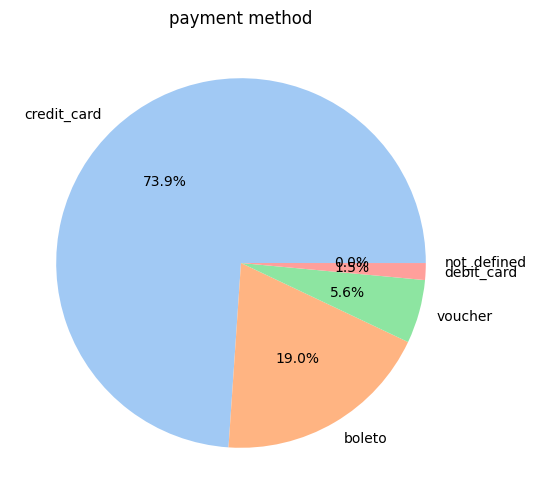

In [16]:
type_count = df_pay["payment_type"].value_counts()
plt.figure(figsize=(6,6))
plt.pie(type_count,labels=type_count.index,autopct="%1.1f%%",colors=sns.color_palette("pastel"))
plt.title("payment method")
plt.show()

____

In [17]:
df_reviews = pd.read_sql("SELECT * FROM dwh.fact_reviews", engine)
df_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_date
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01
...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,None,None,2018-07-07
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,None,None,2017-12-09
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,None,"Excelente mochila, entrega super rápida. Super...",2018-03-22
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,None,None,2018-07-01


In [18]:
query = """
    SELECT 
        r.review_id,
        r.review_score,
        r.review_comment_message,
        o.order_id,
        o.product_id,
        p.category,
        c.customer_state,
        c.customer_city
    FROM dwh.fact_reviews r
    JOIN dwh.fact_orders o ON r.order_id = o.order_id
    JOIN dwh.dim_products p ON o.product_id = p.product_id
    JOIN dwh.dim_customers c ON o.customer_id = c.customer_id
"""

df_reviews = pd.read_sql(query, engine)
df_reviews

,review_id,review_score,review_comment_message,order_id,product_id,category,customer_state,customer_city
0,f99ff17e430a53efe61d359faa3b425e,3,SOLICITEI DEVOLUÇÃO. PRODUTO COM DEFEITO,009838529bb913846ab6670d22865381,36826c711e5778c8d88a7311cc29c446,bed_bath_table,MG,juiz de fora
1,e0f22f5095fcf60e28abd7aed98dadea,4,Muito bom,0098dbda25722a3f019fe252a0cd10b3,568ba441f7f464dc73d23a91cf8ca671,bed_bath_table,GO,sao joao d'alianca
2,4ae1114d0b5853ef79ae803a9a969878,5,None,009905140e9f8cc35d5be897937381db,06edb72f1e0c64b14c5b79353f7abea3,bed_bath_table,GO,goiania
3,4ae1114d0b5853ef79ae803a9a969878,5,None,009905140e9f8cc35d5be897937381db,06edb72f1e0c64b14c5b79353f7abea3,bed_bath_table,GO,goiania
4,aee1f5bdfc0f44fd54ec0567f0dcf73d,1,Pedi um produto e veio outro,00995d799817ecc3bd2abd8fbe59c430,f3b8bfa5b86249e75e5c0632acc0e82e,health_beauty,RJ,sao goncalo
...,...,...,...,...,...,...,...,...
112367,907b6357036c1e0117fb101a2436c888,5,None,ffc0da1000e3fe80b745f005755bb814,d1606c4563d5481c8020de798866465e,health_beauty,RJ,rio de janeiro
112368,359d40dffb0e0f17e472d3e4e70093c9,5,None,ffc184f2119c6fd4140dcfb518bf4734,c72d57da8ba2412527531d97106eb8ef,telephony,SP,itaquaquecetuba
112369,e5d2692fe45a9bf8ceacc0c3b9944528,4,A demora pra entrega é maior que de outros pro...,ffc1be2cfc663c95a4663eae09796e19,3cce0d166c3fb2507956c630c1d0f87c,home_construction,SP,sao sebastiao
112370,6636f9d74ac63e8609355900d5c306e8,5,"Produto frágil, usar com cuidado.\r",ffc1fd8337b12fe96a4c39a0c2991296,3f1a741cf5591384428c1cbb0ef07ec0,health_beauty,SP,osasco


In [19]:
1-df_reviews["review_comment_message"].isna().sum()/len(df_reviews)

np.float64(0.4239668244758481)

In [20]:
def compute_hybrid_sentiment(df_reviews):
    df = df_reviews.copy()

    df['comment_clean'] = df['review_comment_message'].fillna('')

    sia = SentimentIntensityAnalyzer()

    def get_sentiment(text):
        if not text:
            return 0.0
        return sia.polarity_scores(text)['compound']

    df['sentiment_score'] = df['comment_clean'].apply(get_sentiment)

    # Normalize components
    df['norm_stars'] = (df['review_score'] - 1) / 4
    df['norm_sentiment'] = (df['sentiment_score'] + 1) / 2

    # Hybrid logic
    df['raw_hybrid_score'] = np.where(
        df['comment_clean'] == '',
        df['norm_stars'],
        0.5 * df['norm_stars'] + 0.5 * df['norm_sentiment']
    )

    return df

In [21]:
def normalize_satisfaction_score(df, target_mean=50, target_std=15):
    df = df.copy()

    qt = QuantileTransformer(
        output_distribution='normal',
        random_state=42
    )

    df['gaussian_score'] = qt.fit_transform(
        df[['raw_hybrid_score']]
    )

    df['final_satisfaction_score'] = (
        df['gaussian_score'] * target_std
    ) + target_mean

    df['final_satisfaction_score'] = df['final_satisfaction_score'].clip(0, 100)

    return df

In [22]:
def plot_satisfaction_distribution(df):
    plt.figure(figsize=(12, 6))

    sns.histplot(
        df['final_satisfaction_score'],
        kde=True,
        bins=50,
        color='#2D3270'
    )

    plt.axvline(
        50,
        color='red',
        linestyle='--',
        label='Mean (50)'
    )

    plt.title('Final Satisfaction Score (0–100)')
    plt.xlabel('Score')
    plt.legend()
    plt.show()

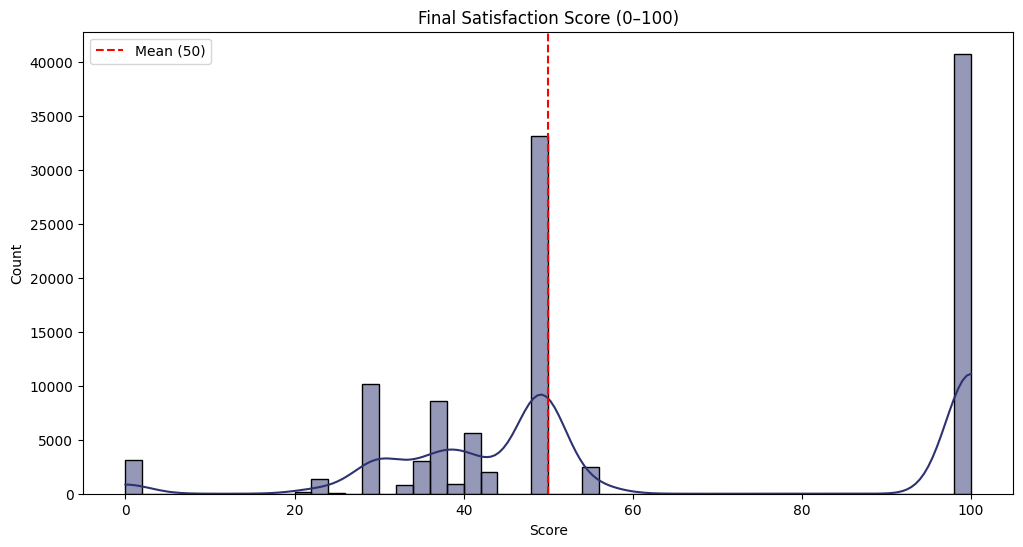

   review_score  sentiment_score  final_satisfaction_score
0             3              0.0                 37.625999
1             4              0.0                 41.269864
2             5              0.0                100.000000
3             5              0.0                100.000000
4             1              0.0                 29.757535
5             4              0.0                 49.171564
6             5              0.0                100.000000
7             5              0.0                 49.171564
8             5              0.0                100.000000
9             4              0.0                 49.171564
count    112372.000000
mean         62.285127
std          29.993740
min           0.000000
25%          39.823512
50%          49.171564
75%         100.000000
max         100.000000
Name: final_satisfaction_score, dtype: float64


In [23]:
df_scored = compute_hybrid_sentiment(df_reviews)
df_scored = normalize_satisfaction_score(df_scored)

plot_satisfaction_distribution(df_scored)

print(
    df_scored[
        ['review_score', 'sentiment_score', 'final_satisfaction_score']
    ].head(10)
)

print(df_scored['final_satisfaction_score'].describe())

In [24]:
df_reviews["satisfaction_score"] = df_scored["final_satisfaction_score"]
df_reviews

,review_id,review_score,review_comment_message,order_id,product_id,category,customer_state,customer_city,satisfaction_score
0,f99ff17e430a53efe61d359faa3b425e,3,SOLICITEI DEVOLUÇÃO. PRODUTO COM DEFEITO,009838529bb913846ab6670d22865381,36826c711e5778c8d88a7311cc29c446,bed_bath_table,MG,juiz de fora,37.625999
1,e0f22f5095fcf60e28abd7aed98dadea,4,Muito bom,0098dbda25722a3f019fe252a0cd10b3,568ba441f7f464dc73d23a91cf8ca671,bed_bath_table,GO,sao joao d'alianca,41.269864
2,4ae1114d0b5853ef79ae803a9a969878,5,None,009905140e9f8cc35d5be897937381db,06edb72f1e0c64b14c5b79353f7abea3,bed_bath_table,GO,goiania,100.000000
3,4ae1114d0b5853ef79ae803a9a969878,5,None,009905140e9f8cc35d5be897937381db,06edb72f1e0c64b14c5b79353f7abea3,bed_bath_table,GO,goiania,100.000000
4,aee1f5bdfc0f44fd54ec0567f0dcf73d,1,Pedi um produto e veio outro,00995d799817ecc3bd2abd8fbe59c430,f3b8bfa5b86249e75e5c0632acc0e82e,health_beauty,RJ,sao goncalo,29.757535
...,...,...,...,...,...,...,...,...,...
112367,907b6357036c1e0117fb101a2436c888,5,None,ffc0da1000e3fe80b745f005755bb814,d1606c4563d5481c8020de798866465e,health_beauty,RJ,rio de janeiro,100.000000
112368,359d40dffb0e0f17e472d3e4e70093c9,5,None,ffc184f2119c6fd4140dcfb518bf4734,c72d57da8ba2412527531d97106eb8ef,telephony,SP,itaquaquecetuba,100.000000
112369,e5d2692fe45a9bf8ceacc0c3b9944528,4,A demora pra entrega é maior que de outros pro...,ffc1be2cfc663c95a4663eae09796e19,3cce0d166c3fb2507956c630c1d0f87c,home_construction,SP,sao sebastiao,41.269864
112370,6636f9d74ac63e8609355900d5c306e8,5,"Produto frágil, usar com cuidado.\r",ffc1fd8337b12fe96a4c39a0c2991296,3f1a741cf5591384428c1cbb0ef07ec0,health_beauty,SP,osasco,49.171564


In [25]:
df = df_reviews.copy()
# Preprocessing
mean_score = df['review_score'].mean()

def clean_text(text):
    return str(text).lower()

df['clean_text'] = df['review_comment_message'].fillna('').apply(clean_text)

# Masks
# Note: Mean is ~4.09. So 1,2,3,4 are below mean. 5 is above.
low_mask = (df['review_score'] < mean_score) & (df['clean_text'].str.len() > 3)
high_mask = (df['review_score'] > mean_score) & (df['clean_text'].str.len() > 3)

# Translation/Mapping Logic
def get_english_label(portuguese_words, sentiment):
    words = set(portuguese_words.split(' / '))
    
    # Keywords
    delivery_keys = {'prazo', 'entrega', 'chegou', 'dias', 'demora', 'atraso', 'rapida', 'antes', 'envio', 'correios'}
    not_received_keys = {'recebi', 'ainda', 'nao', 'aguardando', 'nada'}
    product_keys = {'produto', 'veio', 'defeito', 'qualidade', 'quebrado', 'errado', 'peca', 'material'}
    service_keys = {'atendimento', 'vendedor', 'loja', 'resposta', 'email'}
    recommendation_keys = {'recomendo', 'indico', 'compraria'}
    general_pos_keys = {'bom', 'otimo', 'excelente', 'gostei', 'adoro', 'super', 'parabens'}
    
    # Logic for LOW scores (Reasons for dissatisfaction)
    if sentiment == 'low':
        if not_received_keys.intersection(words):
            return "Order Not Received"
        if delivery_keys.intersection(words):
            return "Delivery Delay / Issues"
        if product_keys.intersection(words):
            return "Product Quality / Defect"
        if service_keys.intersection(words):
            return "Customer Service Issue"
        # Fallback based on common remaining topics
        if 'bom' in words or 'gostei' in words: # Sarcasm or "Good but..."
            return "Mixed Feedback / Partial Satisfaction"
        return "General Dissatisfaction"

    # Logic for HIGH scores (Reasons for satisfaction)
    elif sentiment == 'high':
        if delivery_keys.intersection(words):
            return "Fast / On-time Delivery"
        if product_keys.intersection(words):
            return "Good Product Quality"
        if service_keys.intersection(words):
            return "Great Customer Service"
        if recommendation_keys.intersection(words) or general_pos_keys.intersection(words):
            return "Highly Recommended / General Praise"
        return "General Satisfaction"

# NMF Function
def fit_and_label_english(text_series, sentiment, n_topics=4):
    if len(text_series) < 10:
        return None, None
        
    stopwords_pt = [
        'de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 'não', 'uma', 'os', 'no', 
        'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 
        'seu', 'sua', 'ou', 'ser', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 
        'até', 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem', 
        'nas', 'me', 'esse', 'eles', 'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 
        'meu', 'às', 'minha', 'têm', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 'nós', 
        'tenho', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'estou', 'está', 'sao'
    ]
    
    tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stopwords_pt, max_features=1000)
    tfidf_mat = tfidf.fit_transform(text_series)
    
    nmf = NMF(n_components=n_topics, random_state=42, init='nndsvd').fit(tfidf_mat)
    
    W = nmf.transform(tfidf_mat)
    dominant_topics = W.argmax(axis=1)
    
    feature_names = tfidf.get_feature_names_out()
    topic_labels = {}
    for topic_idx, topic in enumerate(nmf.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-6:-1]] # Take top 5 to be sure
        top_words_str = " / ".join(top_words)
        # Translate immediately
        topic_labels[topic_idx] = get_english_label(top_words_str, sentiment)
        
    return dominant_topics, topic_labels

# Init column
df['satisfaction_reason'] = pd.Series(dtype='object')
df['satisfaction_reason'] = None
df['satisfaction_reason'] = df['satisfaction_reason'].astype('object')
# Process
low_idx, low_labels = fit_and_label_english(df.loc[low_mask, 'clean_text'], 'low')
if low_idx is not None:
    df.loc[low_mask, 'satisfaction_reason'] = [low_labels[i] for i in low_idx]

high_idx, high_labels = fit_and_label_english(df.loc[high_mask, 'clean_text'], 'high')
if high_idx is not None:
    df.loc[high_mask, 'satisfaction_reason'] = [high_labels[i] for i in high_idx]
    
df['satisfaction_reason'].fillna('No Comment / Neutral', inplace=True)
df_reviews = df.drop(columns=["review_comment_message","clean_text"])
df_reviews

C:\Users\mfgas\AppData\Local\Temp\ipykernel_10196\2862132763.py:100: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['satisfaction_reason'].fillna('No Comment / Neutral', inplace=True)


,review_id,review_score,order_id,product_id,category,customer_state,customer_city,satisfaction_score,satisfaction_reason
0,f99ff17e430a53efe61d359faa3b425e,3,009838529bb913846ab6670d22865381,36826c711e5778c8d88a7311cc29c446,bed_bath_table,MG,juiz de fora,37.625999,Order Not Received
1,e0f22f5095fcf60e28abd7aed98dadea,4,0098dbda25722a3f019fe252a0cd10b3,568ba441f7f464dc73d23a91cf8ca671,bed_bath_table,GO,sao joao d'alianca,41.269864,Product Quality / Defect
2,4ae1114d0b5853ef79ae803a9a969878,5,009905140e9f8cc35d5be897937381db,06edb72f1e0c64b14c5b79353f7abea3,bed_bath_table,GO,goiania,100.000000,No Comment / Neutral
3,4ae1114d0b5853ef79ae803a9a969878,5,009905140e9f8cc35d5be897937381db,06edb72f1e0c64b14c5b79353f7abea3,bed_bath_table,GO,goiania,100.000000,No Comment / Neutral
4,aee1f5bdfc0f44fd54ec0567f0dcf73d,1,00995d799817ecc3bd2abd8fbe59c430,f3b8bfa5b86249e75e5c0632acc0e82e,health_beauty,RJ,sao goncalo,29.757535,Product Quality / Defect
...,...,...,...,...,...,...,...,...,...
112367,907b6357036c1e0117fb101a2436c888,5,ffc0da1000e3fe80b745f005755bb814,d1606c4563d5481c8020de798866465e,health_beauty,RJ,rio de janeiro,100.000000,No Comment / Neutral
112368,359d40dffb0e0f17e472d3e4e70093c9,5,ffc184f2119c6fd4140dcfb518bf4734,c72d57da8ba2412527531d97106eb8ef,telephony,SP,itaquaquecetuba,100.000000,No Comment / Neutral
112369,e5d2692fe45a9bf8ceacc0c3b9944528,4,ffc1be2cfc663c95a4663eae09796e19,3cce0d166c3fb2507956c630c1d0f87c,home_construction,SP,sao sebastiao,41.269864,Product Quality / Defect
112370,6636f9d74ac63e8609355900d5c306e8,5,ffc1fd8337b12fe96a4c39a0c2991296,3f1a741cf5591384428c1cbb0ef07ec0,health_beauty,SP,osasco,49.171564,Fast / On-time Delivery


In [26]:
df_reviews.satisfaction_reason.unique()

array(['Order Not Received', 'Product Quality / Defect',
       'No Comment / Neutral', 'Fast / On-time Delivery',
       'Delivery Delay / Issues', 'Good Product Quality'], dtype=object)

In [27]:
df_prods.to_sql('dim_products', engine, schema='dwh', if_exists='replace', index=False)

df_reviews.to_sql('fact_reviews', engine, schema='dwh', if_exists='replace', index=False)

with engine.begin() as conn:
    conn.execute(text("CREATE INDEX idx_dim_prod_id ON dwh.dim_products(product_id)"))
    conn.execute(text("CREATE INDEX idx_fact_rev_order_id ON dwh.fact_reviews(order_id)"))
    
print("Successfully replaced dim_products and fact_reviews in DWH.")

Successfully replaced dim_products and fact_reviews in DWH.
